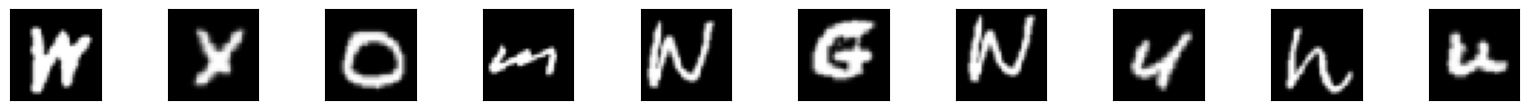

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loaded_images = utils.load_images_from_zip()
emnist_data, emnist_labels = utils.load_true_emnist()

emnist_data = emnist_data.astype(np.float32)
loaded_images = loaded_images.astype(np.float32)

utils.plot_images(loaded_images[10:20])

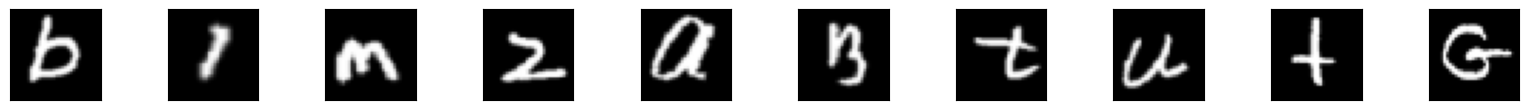

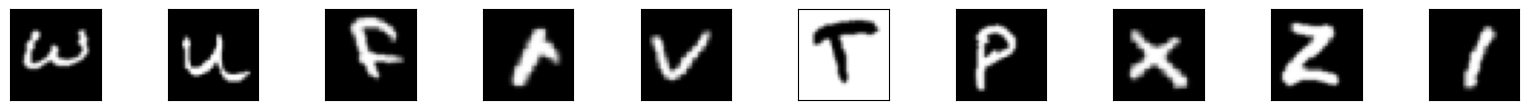

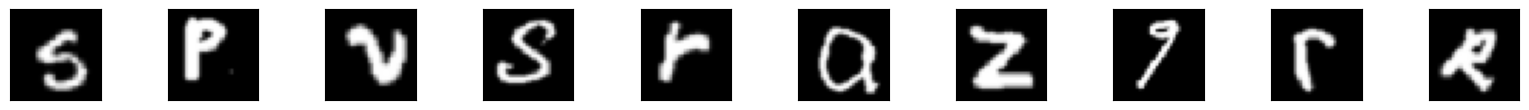

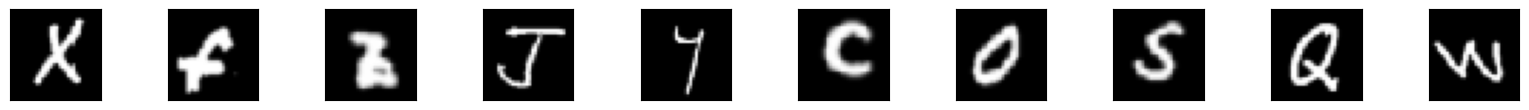

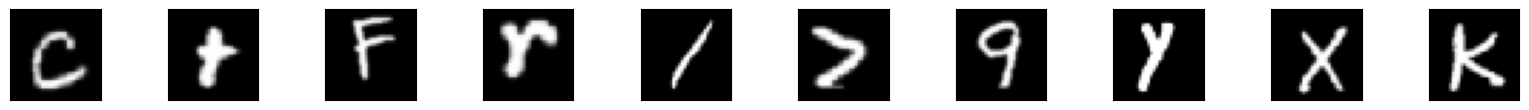

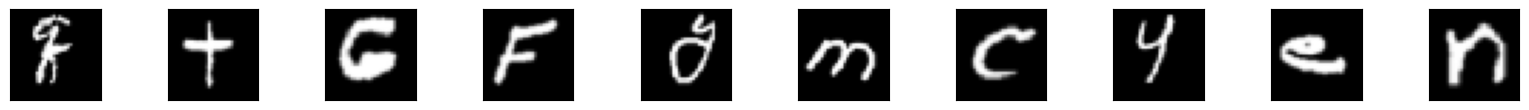

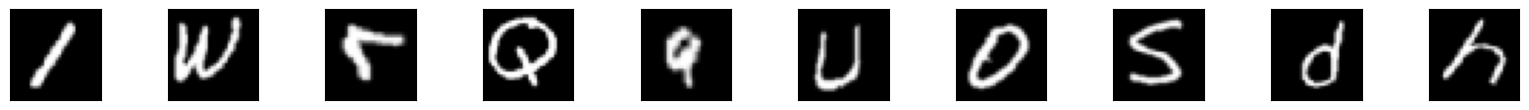

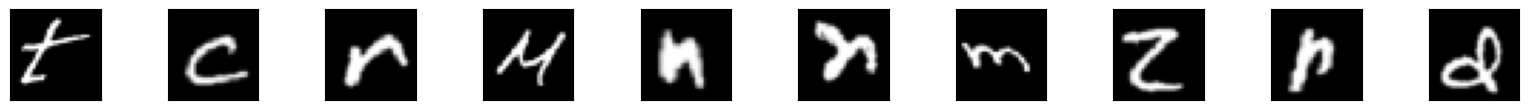

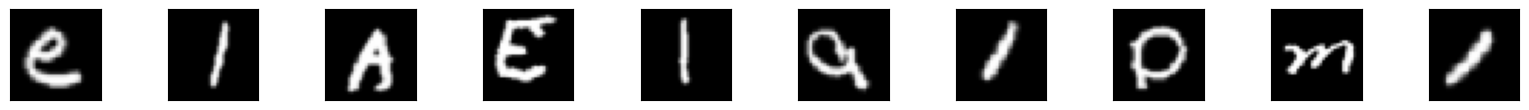

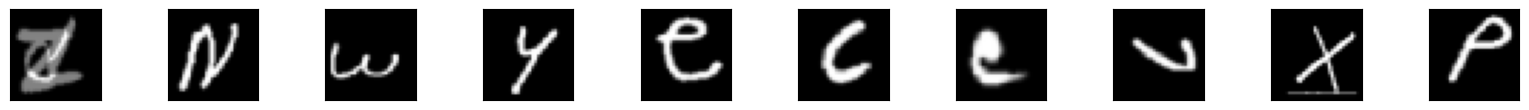

In [2]:
indexes = np.random.choice(len(loaded_images), 100, replace=False)
data = torch.tensor(loaded_images[indexes]).float().to(device)
utils.plot_images(data)

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim

loaded_images_nn = torch.tensor(
    np.reshape(loaded_images, (len(loaded_images), 32 * 32)), 
    device=device,
    dtype=torch.float32
    )
data_train, data_test = train_test_split(loaded_images_nn, test_size=0.2, random_state=1)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=256, shuffle=False)


In [29]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=data_train.shape[1]):
        super(Autoencoder, self).__init__()
        self.img_size = int(np.sqrt(input_dim))
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8 * (self.img_size//4) * (self.img_size//4), 32),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 8 * (self.img_size//4) * (self.img_size//4)),
            nn.ReLU(),
            Reshape(-1, 8, self.img_size//4, self.img_size//4),
            nn.ConvTranspose2d(8, 16, 
                              kernel_size=3, 
                              stride=2, 
                              padding=1, 
                              output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                              kernel_size=3, 
                              stride=2, 
                              padding=1, 
                              output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.view(-1, 1, self.img_size, self.img_size)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, self.img_size * self.img_size)

In [24]:
model = Autoencoder()
model = model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [33]:
def train_model(model, loss_fn, data_loader=None, epochs=10, optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))


In [34]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/104845 (0%)]	Loss: 0.055044
Train Epoch: 0 [25600/104845 (24%)]	Loss: 0.040627
Train Epoch: 0 [51200/104845 (49%)]	Loss: 0.034228
Train Epoch: 0 [76800/104845 (73%)]	Loss: 0.030850
Train Epoch: 0 [102400/104845 (98%)]	Loss: 0.030327
Train Epoch: 1 [0/104845 (0%)]	Loss: 0.030110
Train Epoch: 1 [25600/104845 (24%)]	Loss: 0.029102
Train Epoch: 1 [51200/104845 (49%)]	Loss: 0.029019
Train Epoch: 1 [76800/104845 (73%)]	Loss: 0.028942
Train Epoch: 1 [102400/104845 (98%)]	Loss: 0.026072
Train Epoch: 2 [0/104845 (0%)]	Loss: 0.026191
Train Epoch: 2 [25600/104845 (24%)]	Loss: 0.025210
Train Epoch: 2 [51200/104845 (49%)]	Loss: 0.023747
Train Epoch: 2 [76800/104845 (73%)]	Loss: 0.024262
Train Epoch: 2 [102400/104845 (98%)]	Loss: 0.024664
Train Epoch: 3 [0/104845 (0%)]	Loss: 0.026486
Train Epoch: 3 [25600/104845 (24%)]	Loss: 0.022786
Train Epoch: 3 [51200/104845 (49%)]	Loss: 0.023903
Train Epoch: 3 [76800/104845 (73%)]	Loss: 0.024877
Train Epoch: 3 [102400/104845 (98%)]	Loss: 0.024

In [28]:
from utils import to_img

def plot_reconstructions2(model, data, base_dim=32):
    """
    Plot reconstructions from a dataset set.
    The top row is the original digits,
    the middle row is the encoded vector,
    and the bottom row is the decoder reconstruction.
    """
    
    true_imgs = data
    # Reshape data for the encoder
    data = data.view(-1, 1, base_dim, base_dim)  # Add this line
    # Encode and then decode the images
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    # Convert images for plotting
    true_imgs = to_img(true_imgs, base_dim=base_dim)
    decoded_imgs = to_img(decoded_imgs, base_dim=base_dim)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10  # Number of images to display at the same time
    for j in range(0, len(data), 10):
        plt.figure(figsize=(20, 4))
        for i in range(n):
            if i+j >= len(data):
                break
            # Display original images
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(true_imgs[i + j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Display encoded representations
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(encoded_imgs[i + j].reshape(-1, 4))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Display reconstructed images
            ax = plt.subplot(3, n, i + 1 + 2 * n)
            plt.imshow(decoded_imgs[i + j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

/var/folders/3l/_hdyb1rx2yq_frxtjyy_t_7m0000gn/T/ipykernel_24019/827936534.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 4))


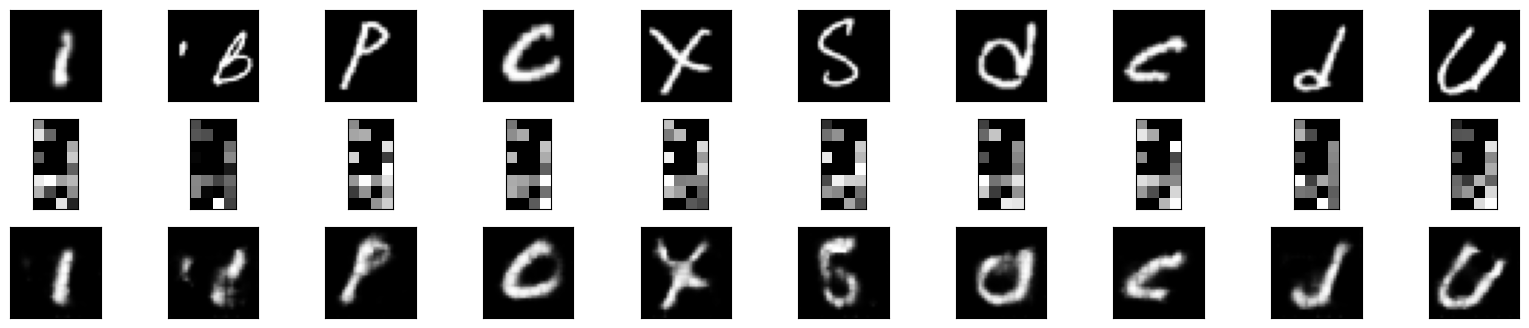

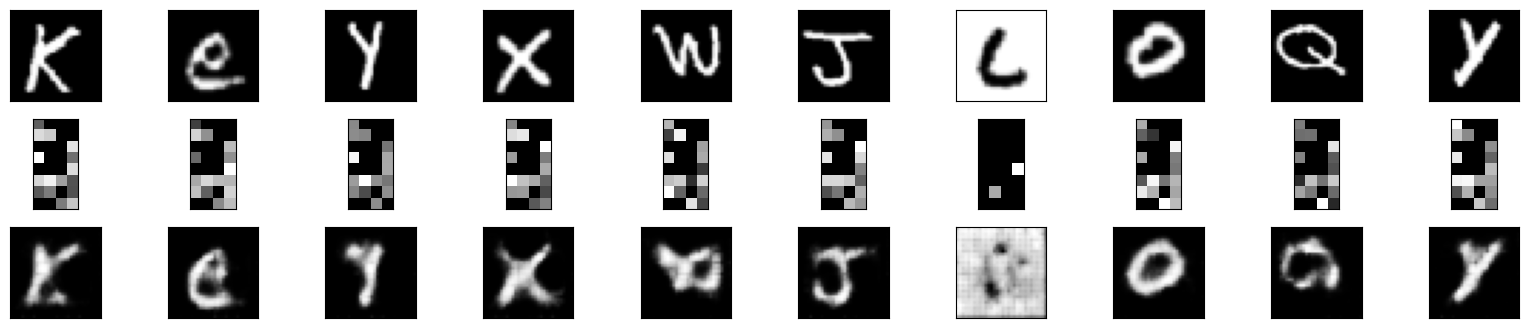

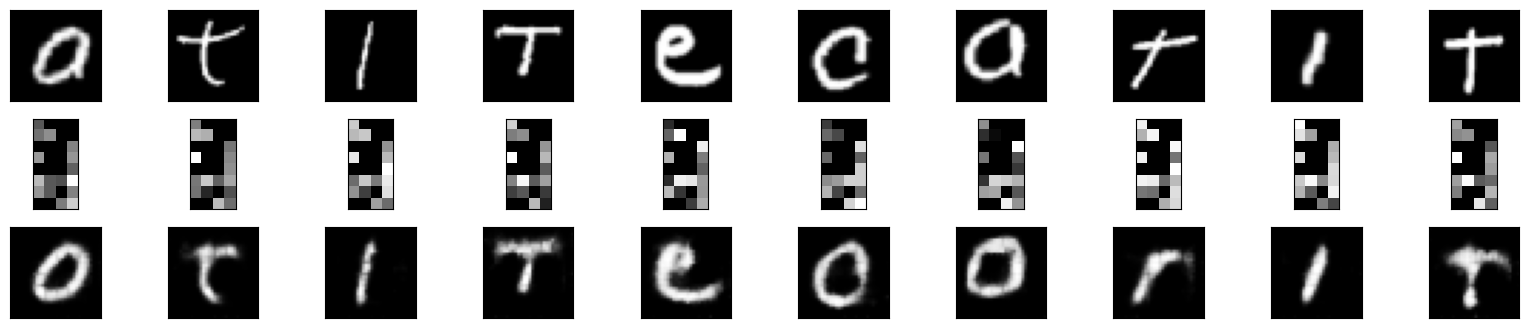

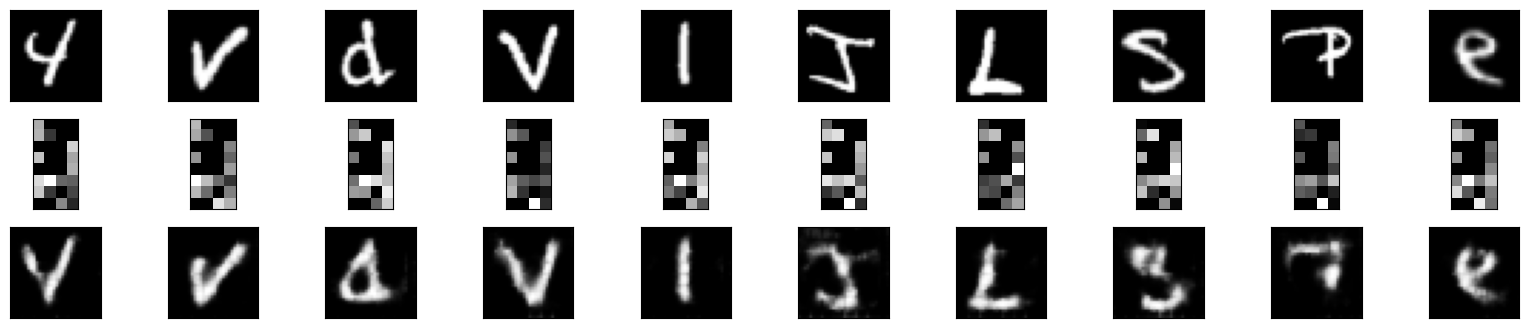

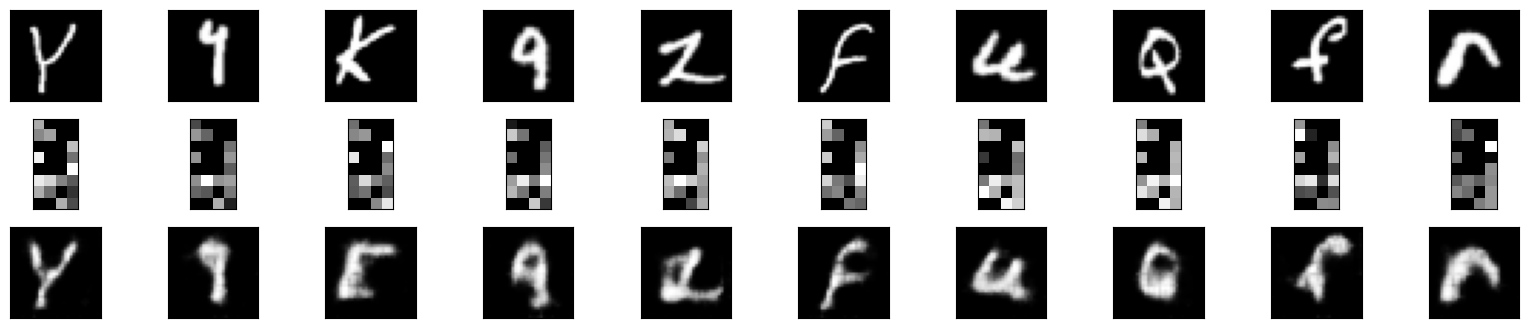

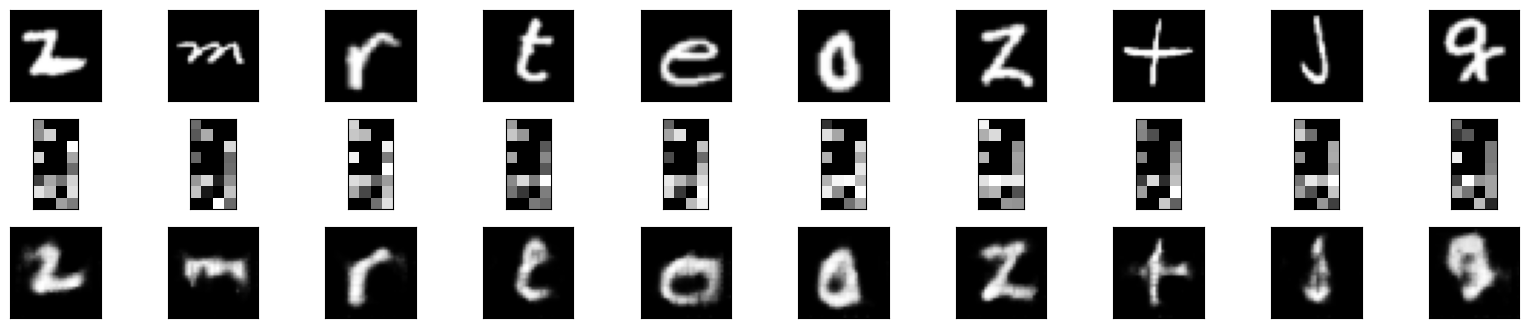

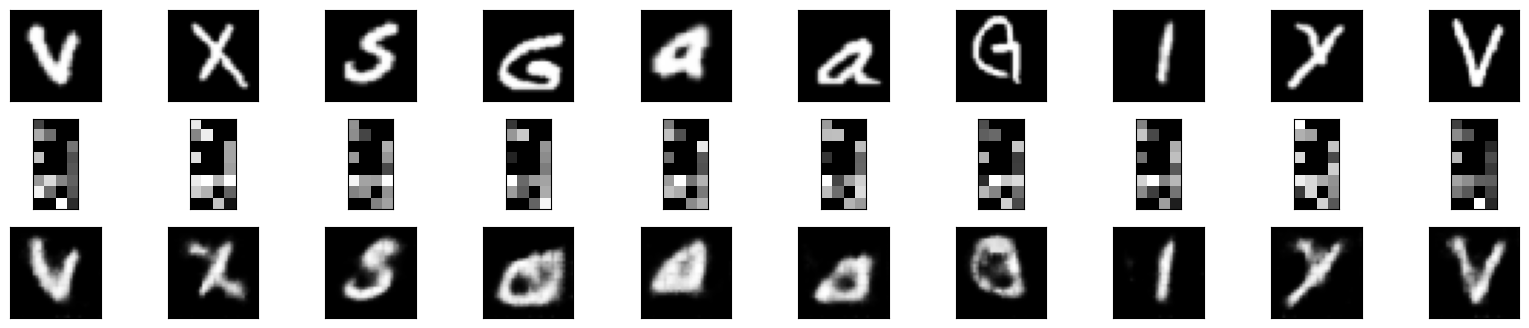

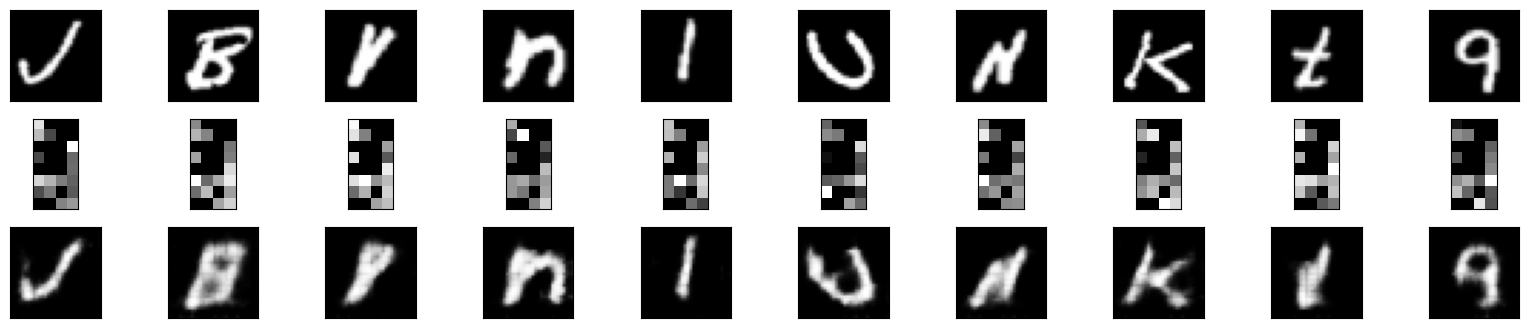

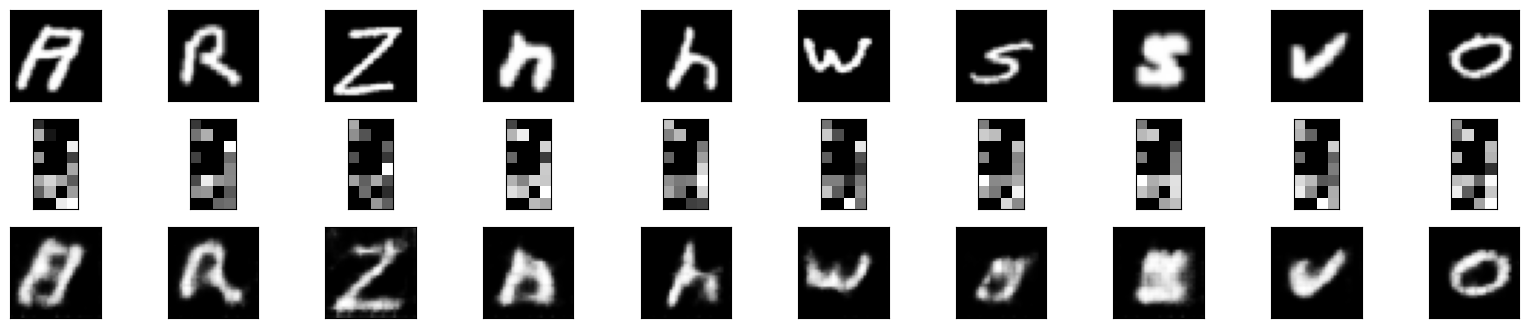

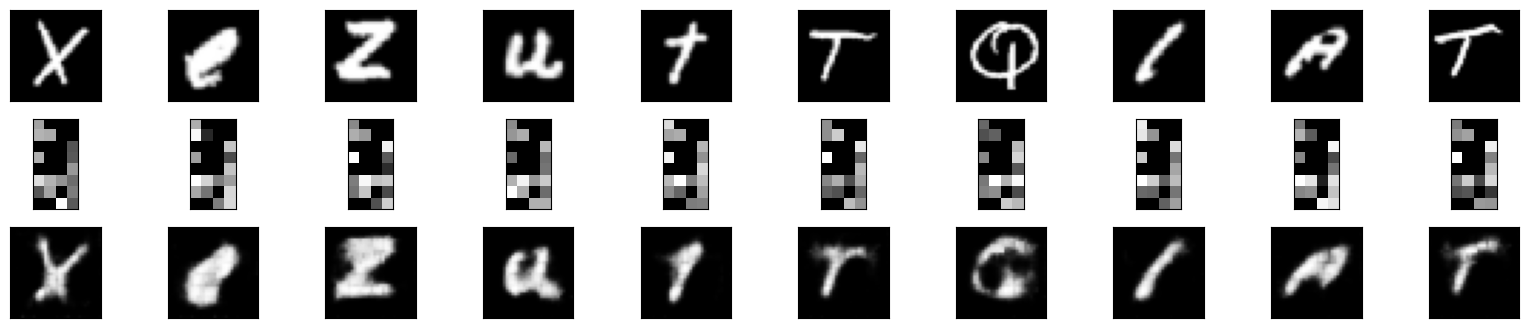

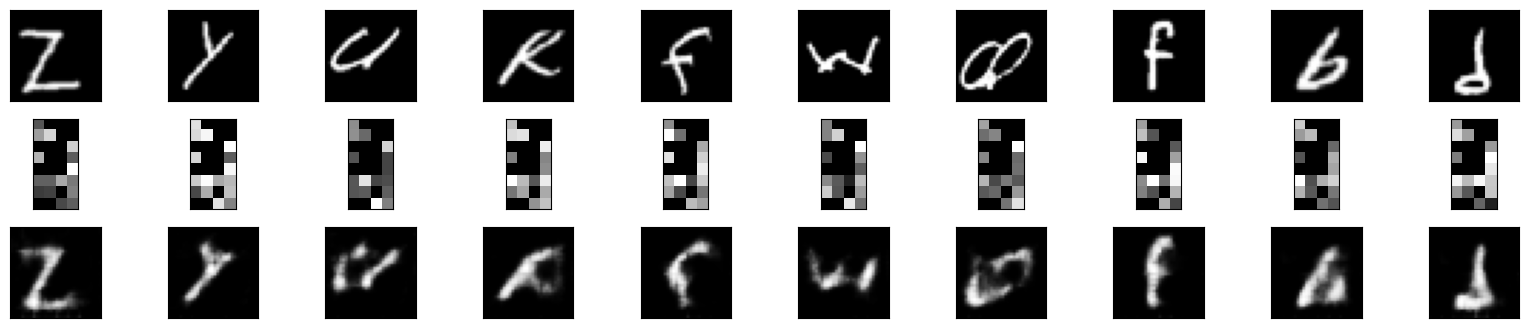

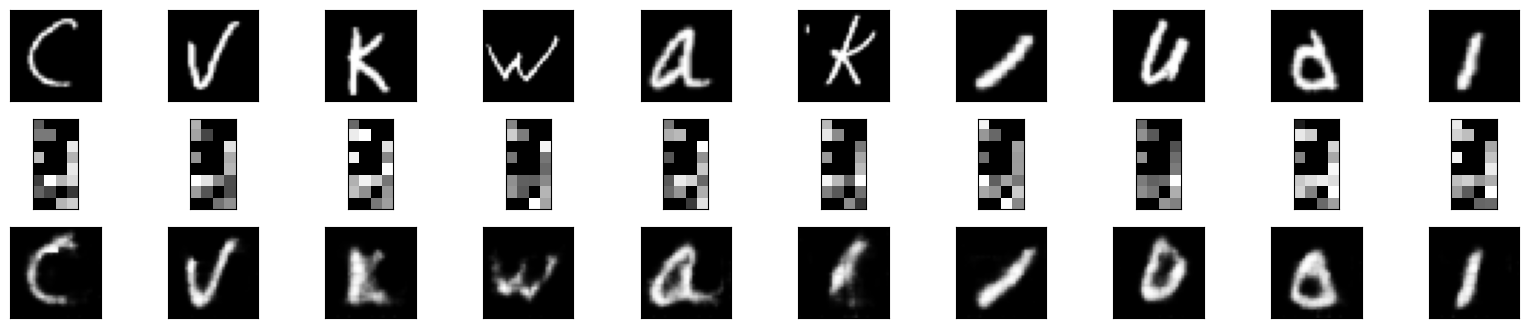

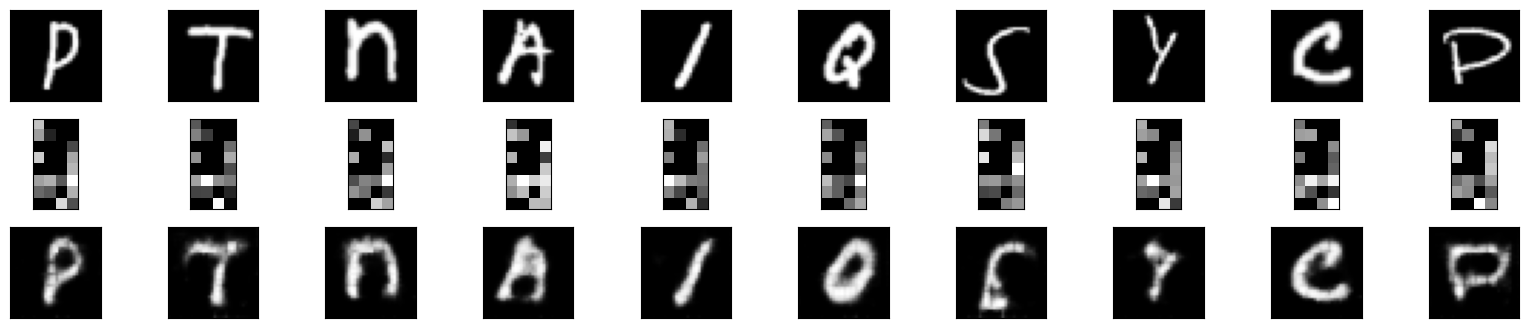

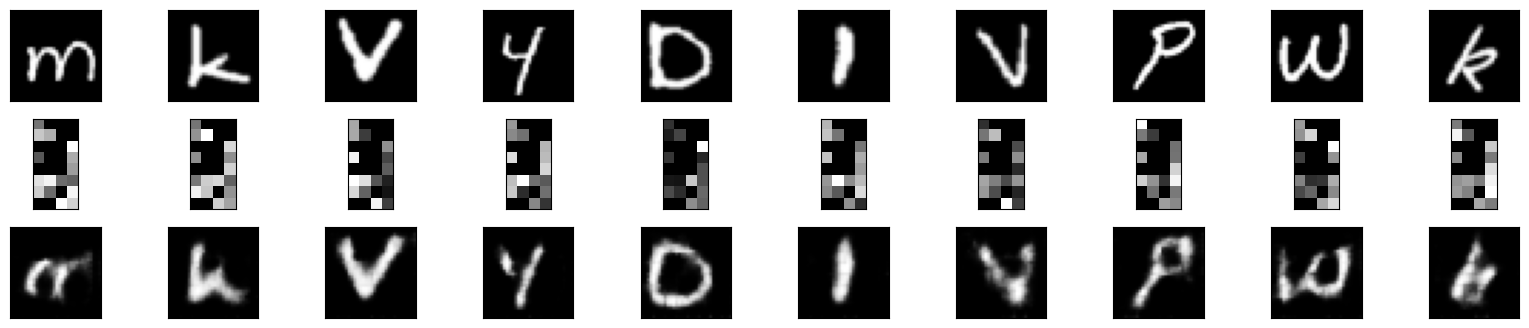

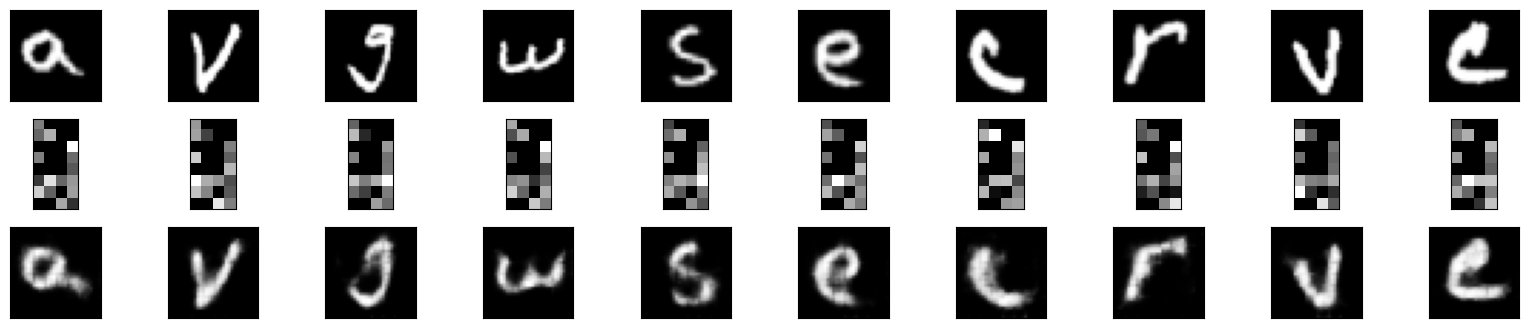

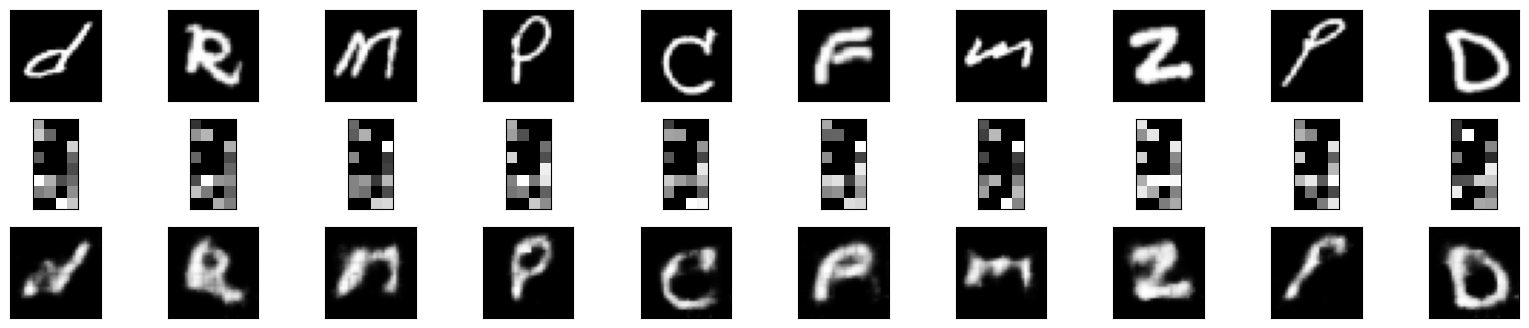

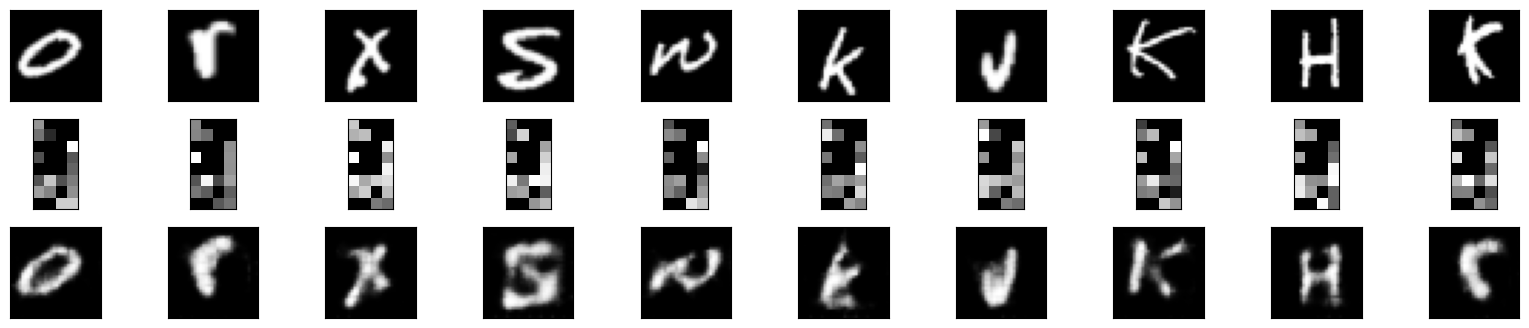

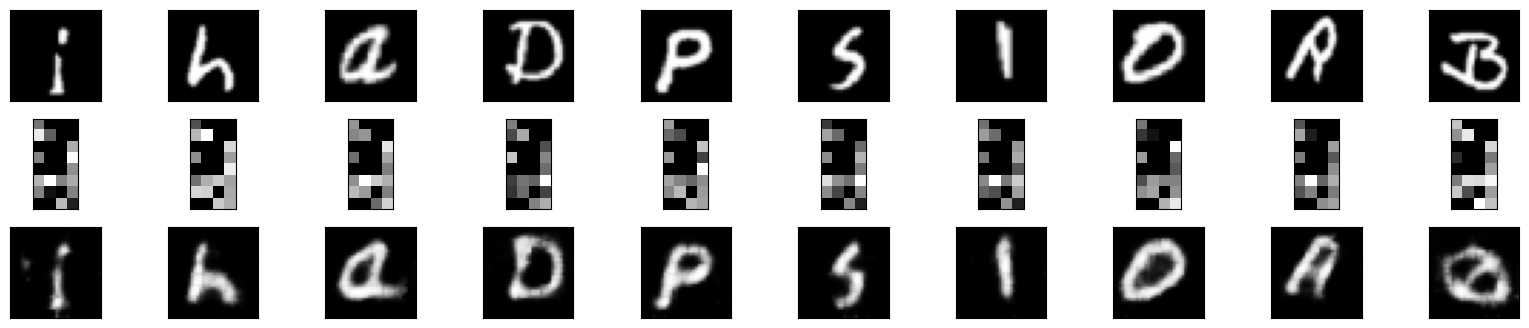

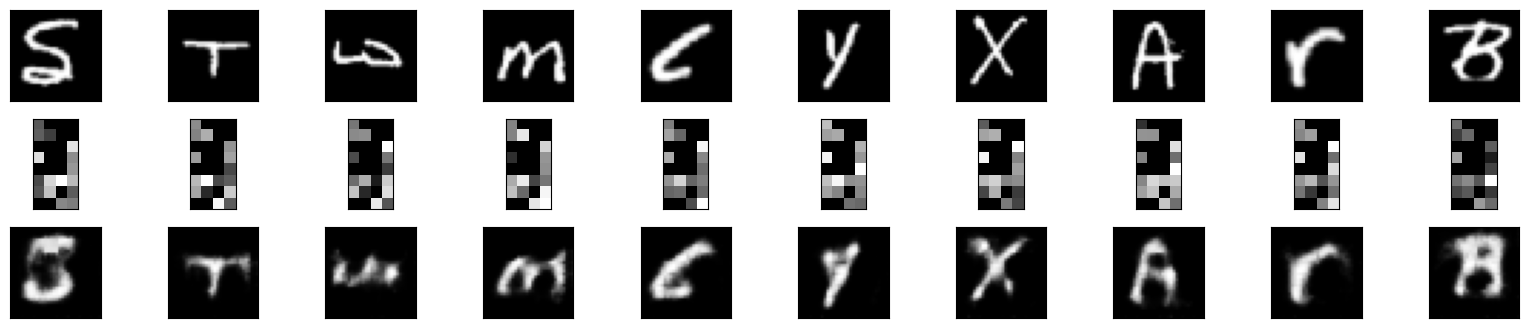

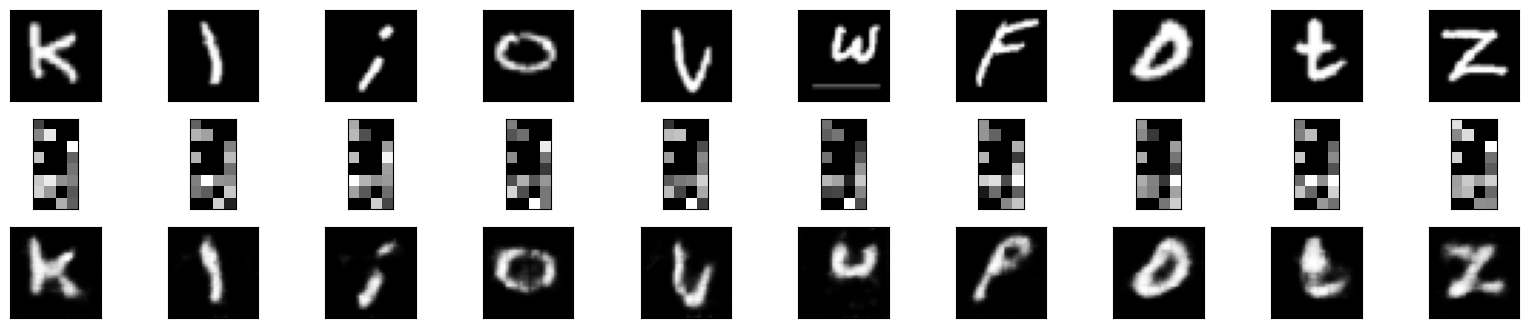

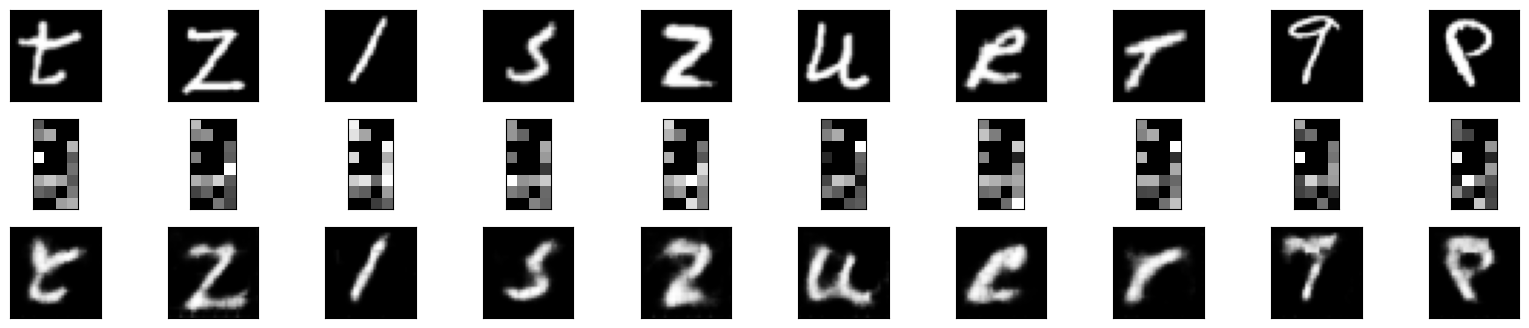

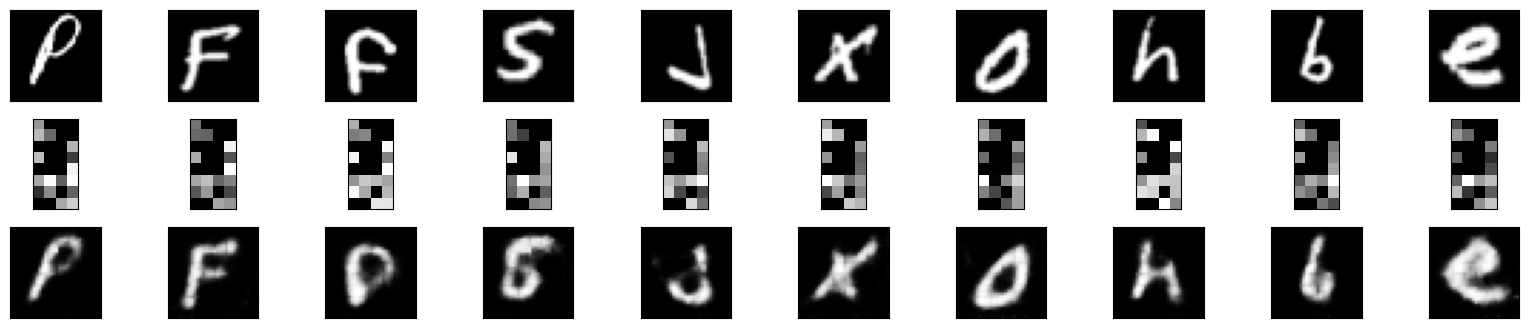

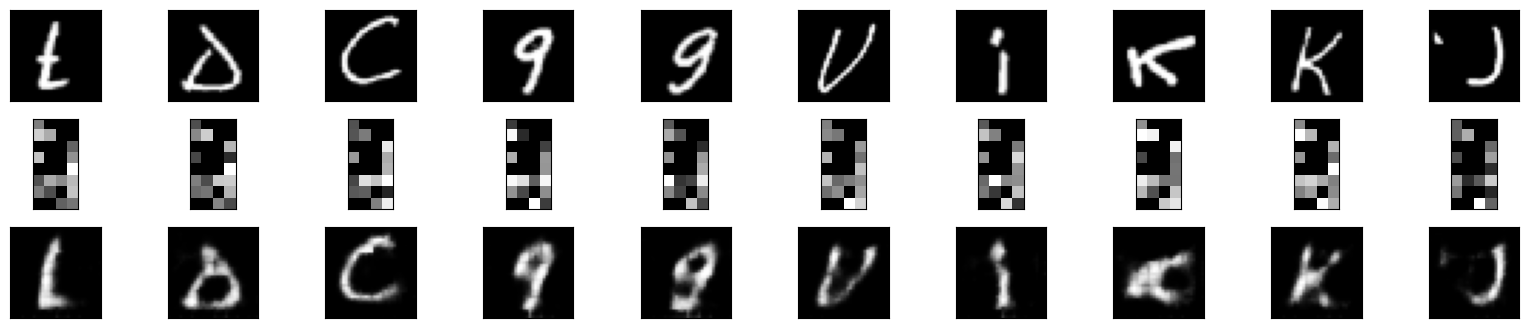

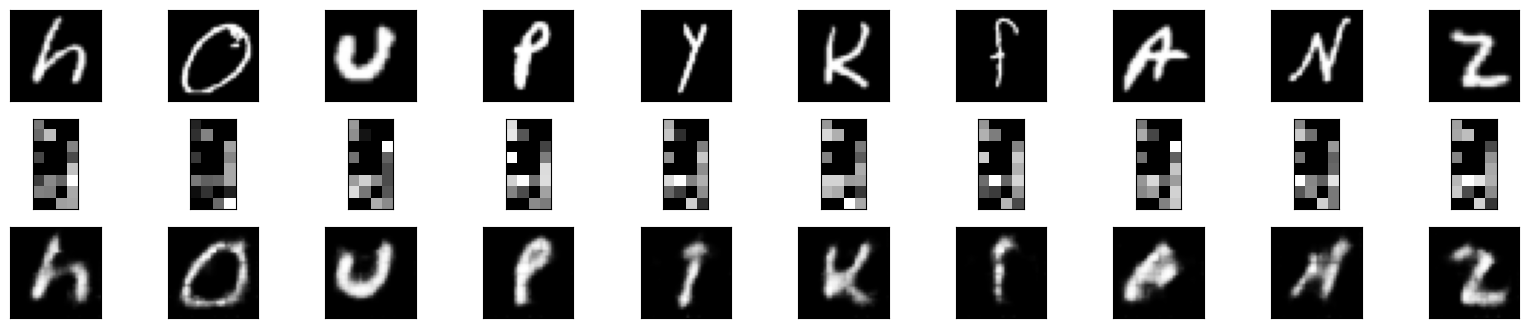

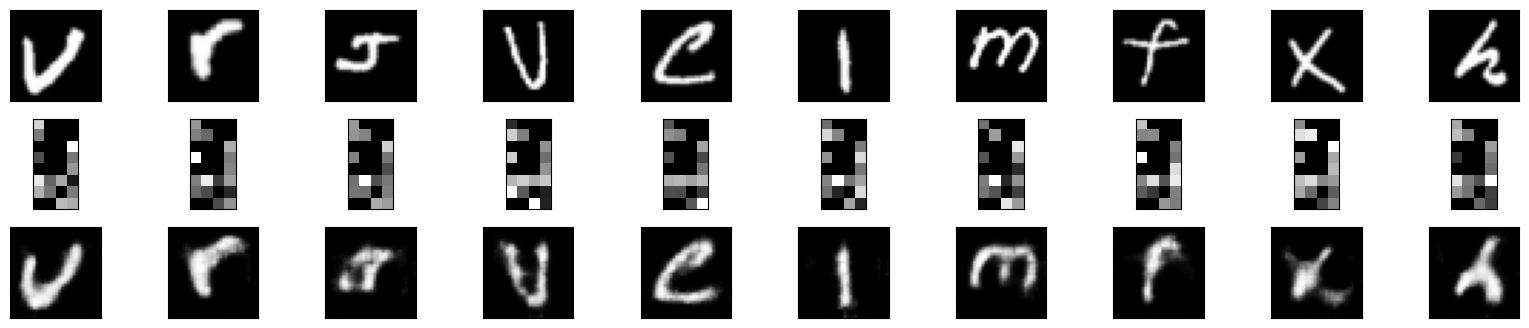

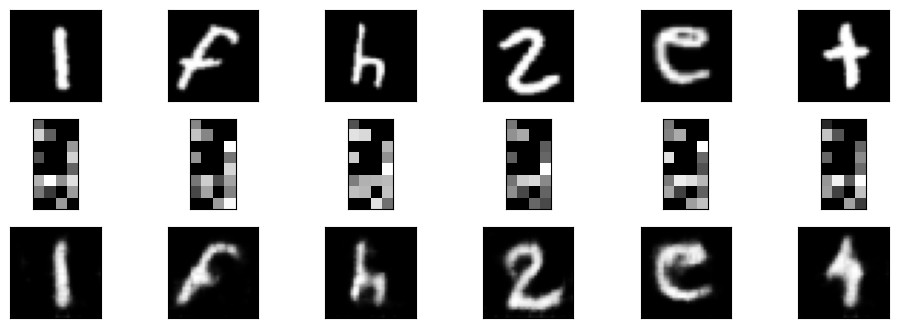

In [35]:
data_viz = next(iter(test_loader))
plot_reconstructions2(model, data_viz)

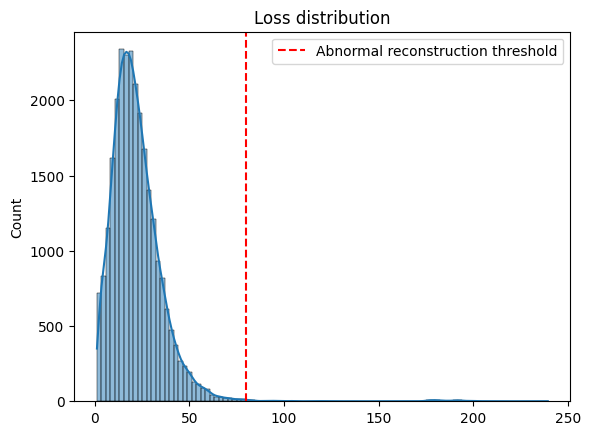

In [36]:
import seaborn as sns

eval_loss = torch.nn.MSELoss(reduction='none')
losses = eval_loss(model(data_test), data_test).sum(axis=1).detach().cpu().numpy()


sns.histplot(losses, bins=100, kde=True)
plt.axvline(x=80, color='r', linestyle='--', label='Abnormal reconstruction threshold')
plt.title('Loss distribution')
plt.legend()
plt.show()

torch.Size([95, 1024])


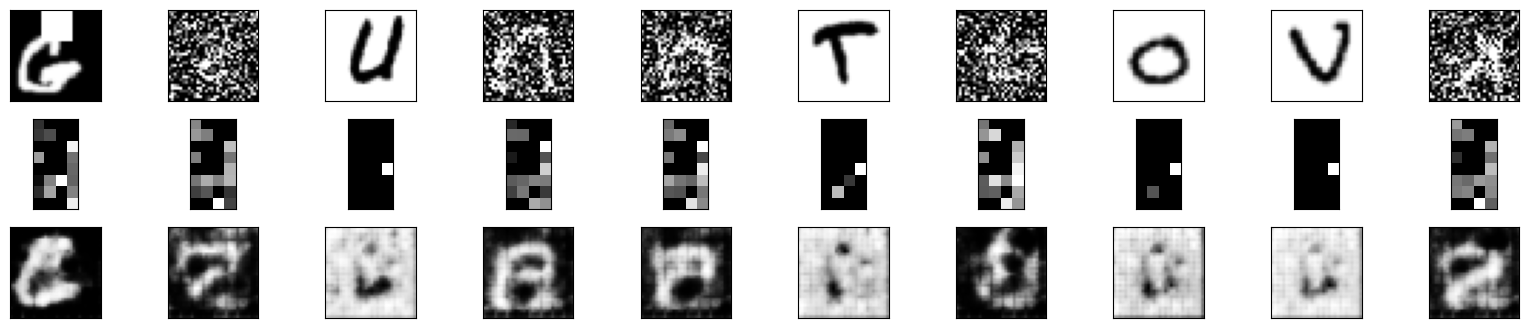

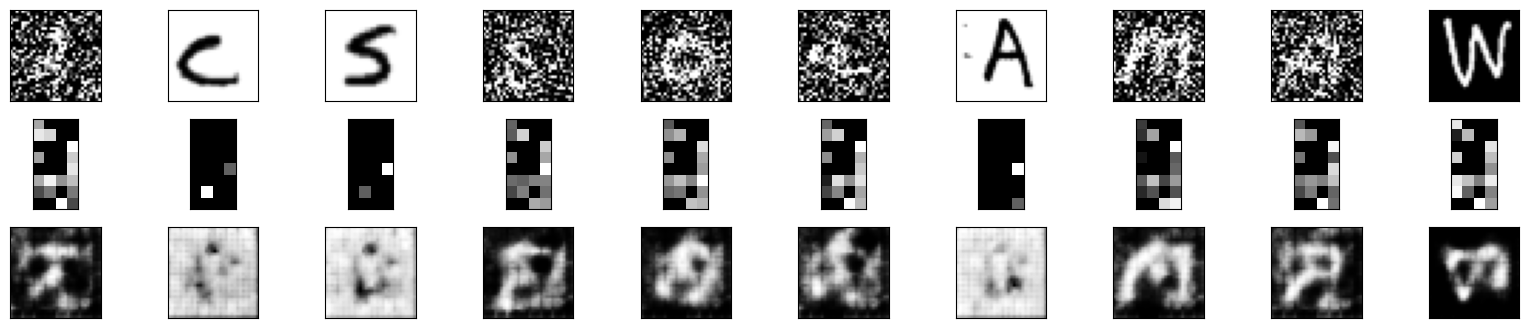

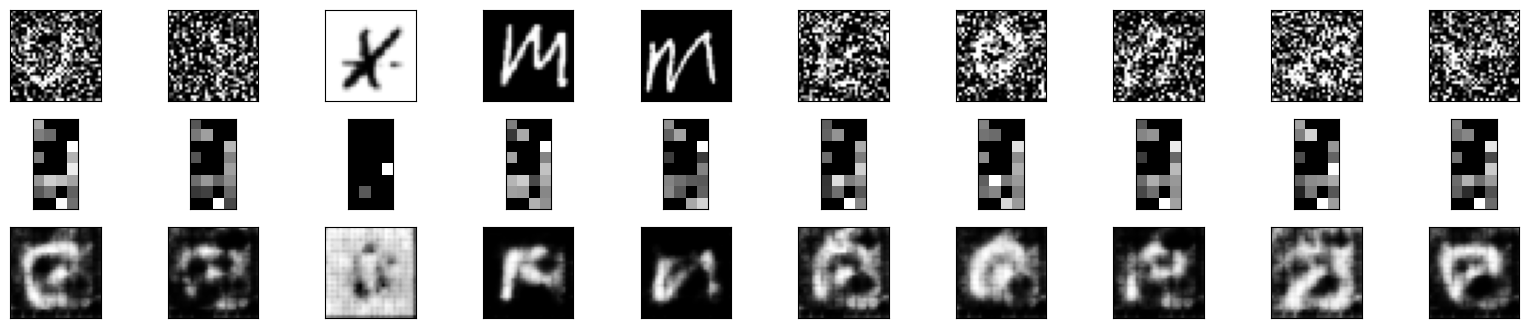

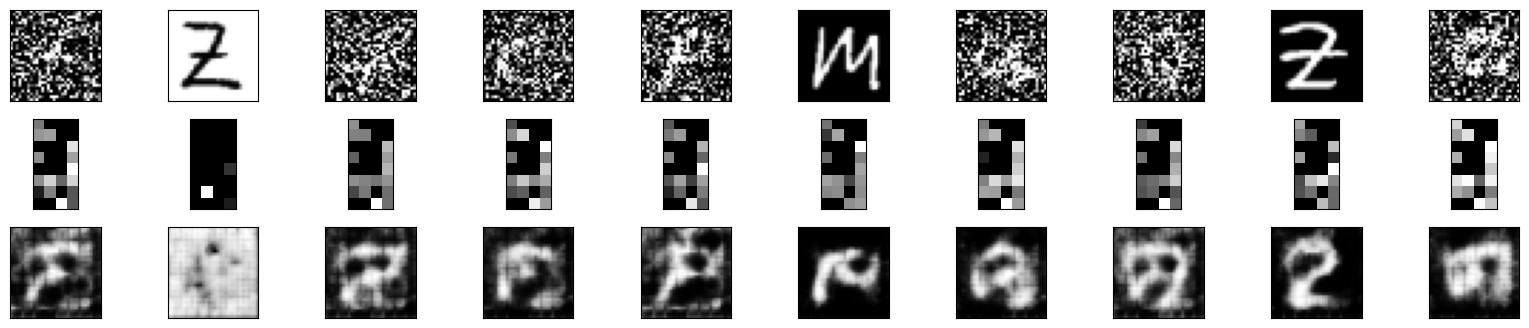

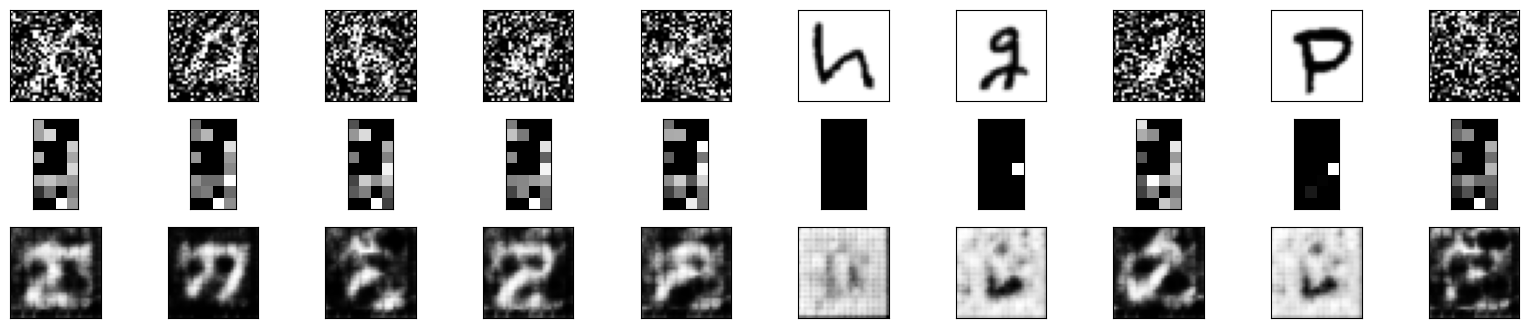

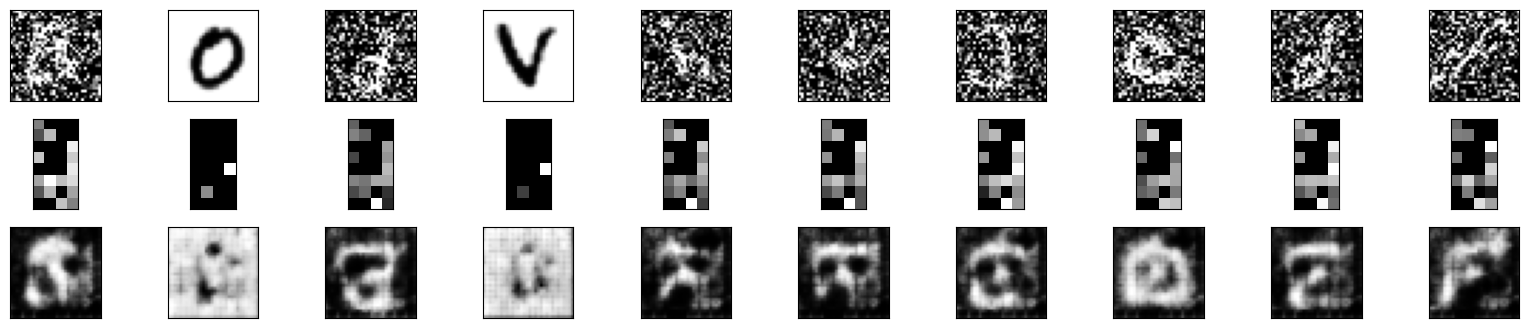

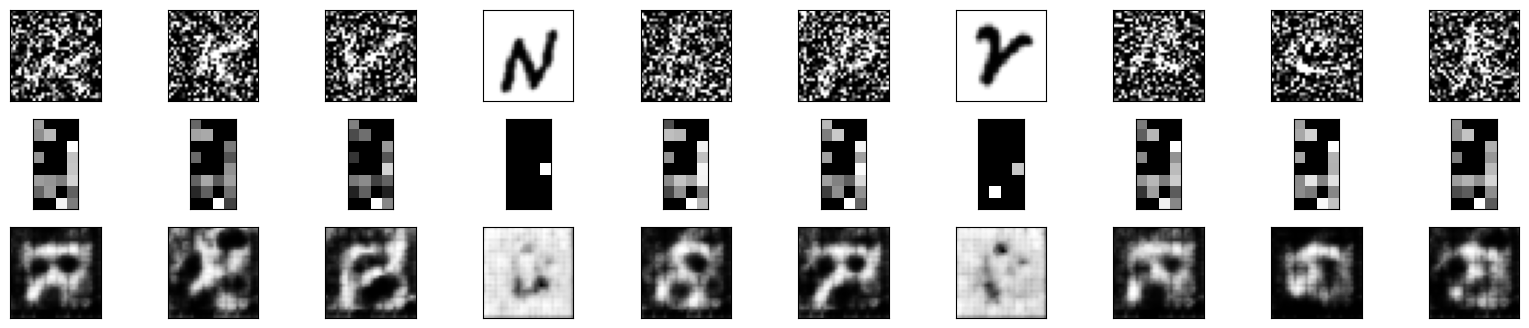

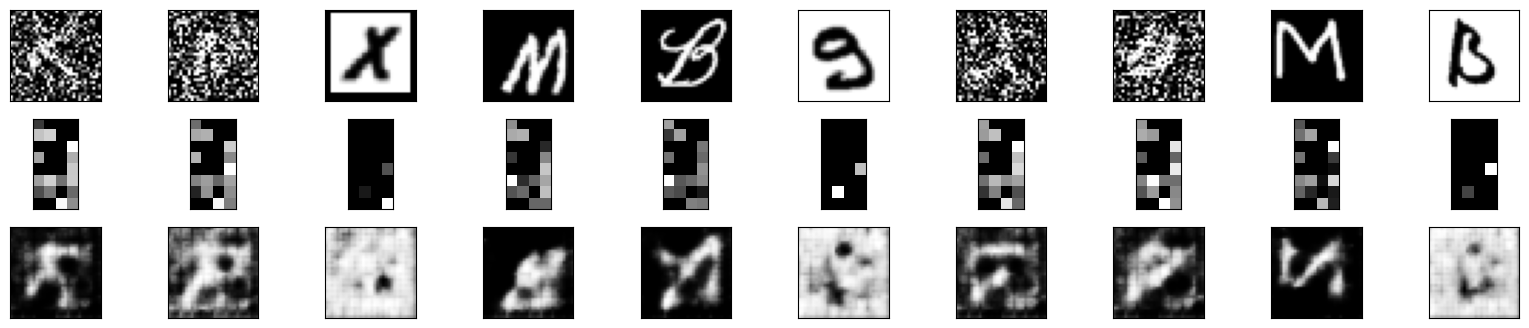

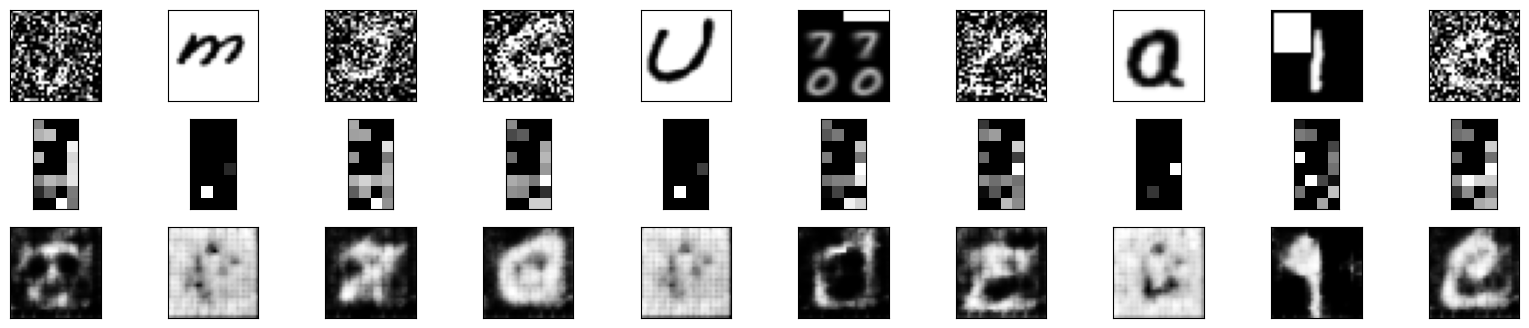

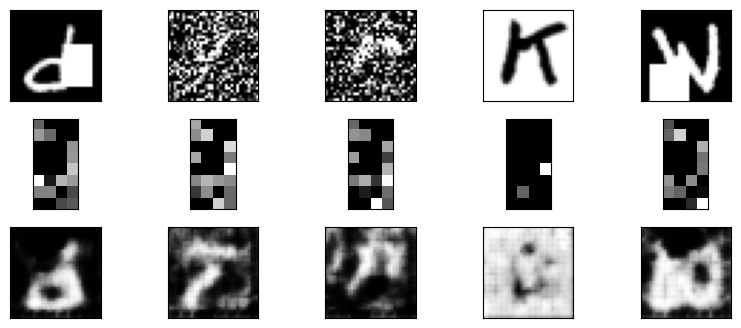

In [37]:
mask = losses > 80
outliers = data_test[mask]
print(outliers.shape)
plot_reconstructions2(model, outliers)